In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip -q /content/gdrive/MyDrive/kaggle/fruits/fruitnet-indian-fruits-dataset-with-quality.zip -d /content/dataset 

replace /content/dataset/Processed Images_Fruits/Bad Quality_Fruits/Apple_Bad/IMG20200728175856.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.simplefilter("ignore")


Train, test, validation dataframes

In [ ]:
sdir=r'/content/gdrive/rive/kaggle/fruits/dataset/Processed Images_Fruits'
bad_path=r'/content/gdrive/MyDrive/kaggle/fruits/dataset/Processed Images_Fruits/Bad Quality_Fruits'
good_path=r'/content/gdrive/MyDrive/kaggle/fruits/dataset/Processed Images_Fruits/Good Quality_Fruits'
mixed_path=r'/content/gdrive/MyDrive/kaggle/fruits/dataset/Processed Images_Fruits/Mixed Qualit_Fruits'
filepaths=[]
labels=[]
ht=0
wt=0
samples=0
sample_count=20
for quality in [bad_path, good_path, mixed_path]:    
    fruit_list=os.listdir(quality)
    for fruit in fruit_list:
        fruit_path=os.path.join(quality, fruit)
        img_list=os.listdir(fruit_path)
        for i, img in enumerate(img_list):
            img_path=os.path.join(fruit_path, img)
            if i < sample_count:
                img=plt.imread(img_path)               
                ht += img.shape[0]
                wt += img.shape[1]
                samples +=1
            filepaths.append(img_path)
            if quality == mixed_path:
                labels.append(fruit + '_mixed')
            else:
                labels.append(fruit)
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)

trsplit=.9
vsplit=.05
dsplit =vsplit/(1-trsplit)
strat=df['labels']
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=strat)
strat=dummy_df['labels']
test_df, valid_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
classes=list(train_df['labels'].unique())
class_count = len(classes)
groups=df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
for label in train_df['labels'].unique():
      group=groups.get_group(label)
      samples=len(group)
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))
wave=wt/samples
have=ht/samples
aspect_ratio= have/wave
print ('Average Image Height: ' ,have, '  Average Image Width: ', wave, '  Aspect ratio: ', aspect_ratio)

train_df lenght:  17645   test_df length:  980   valid_df length:  981
            CLASS               IMAGE COUNT 
       Pomegranate_Good            5940     
          Apple_Bad                1141     
           Lime_Bad                1085     
          Guava_Bad                1129     
       Pomegranate_Bad             1187     
          Lime_Good                1094     
          Apple_Good               1149     
         Orange_mixed               125     
          Orange_Bad               1239     
          Guava_Good               1152     
          Banana_Bad               1087     
         Apple_mixed                113     
         Banana_Good               1113     
         Orange_Good               1216     
      Pomegranate_mixed             125     
         Guava_mixed                148     
         Banana_mixed               285     
         Lemon_mixed                278     
Average Image Height:  311.2517985611511   Average Image Width:  298.58992

Trimming Dataframe

In [ ]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [ ]:
max_samples=300
min_samples=0
column = 'labels'
train_df=trim(train_df, max_samples, min_samples, column)

Original Number of classes in dataframe:  18
[300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 256, 250, 133, 113, 113, 102]


Balance train dataframe

In [ ]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
      
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels')
    for label in train_df['labels'].unique():              
        group=groups.get_group(label)
        sample_count=len(group) 
        if sample_count< max_samples:
            aug_img_count=0
            delta=max_samples-sample_count
            target_dir=os.path.join(aug_dir, label)
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
   
    print (list(train_df['labels'].value_counts()) )
    return train_df 

In [ ]:
working_dir=r'./'
img_size=(300,300)
train_df=balance(train_df, max_samples, min_samples, column, working_dir, img_size)

Original Number of classes in dataframe:  18
[300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 256, 250, 133, 113, 113, 102]
Found 113 validated image filenames.
Found 102 validated image filenames.
Found 113 validated image filenames.
Found 133 validated image filenames.
Found 256 validated image filenames.
Found 250 validated image filenames.
Total Augmented images created=  833
[300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300]


Create the train_gen, test_gen and valid_gen

In [ ]:
batch_size=20
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

Found 5400 validated image filenames belonging to 18 classes.
Found 981 validated image filenames belonging to 18 classes.
Found 980 validated image filenames belonging to 18 classes.
test batch size:  70   test steps:  14  number of classes :  18
       class name        class index 
        Apple_Bad             0      
       Apple_Good             1      
       Apple_mixed            2      
       Banana_Bad             3      
       Banana_Good            4      
      Banana_mixed            5      
        Guava_Bad             6      
       Guava_Good             7      
       Guava_mixed            8      
       Lemon_mixed            9      
        Lime_Bad              10     
        Lime_Good             11     
       Orange_Bad             12     
       Orange_Good            13     
      Orange_mixed            14     
     Pomegranate_Bad          15     
    Pomegranate_Good          16     
    Pomegranate_mixed         17     




Showing example training images

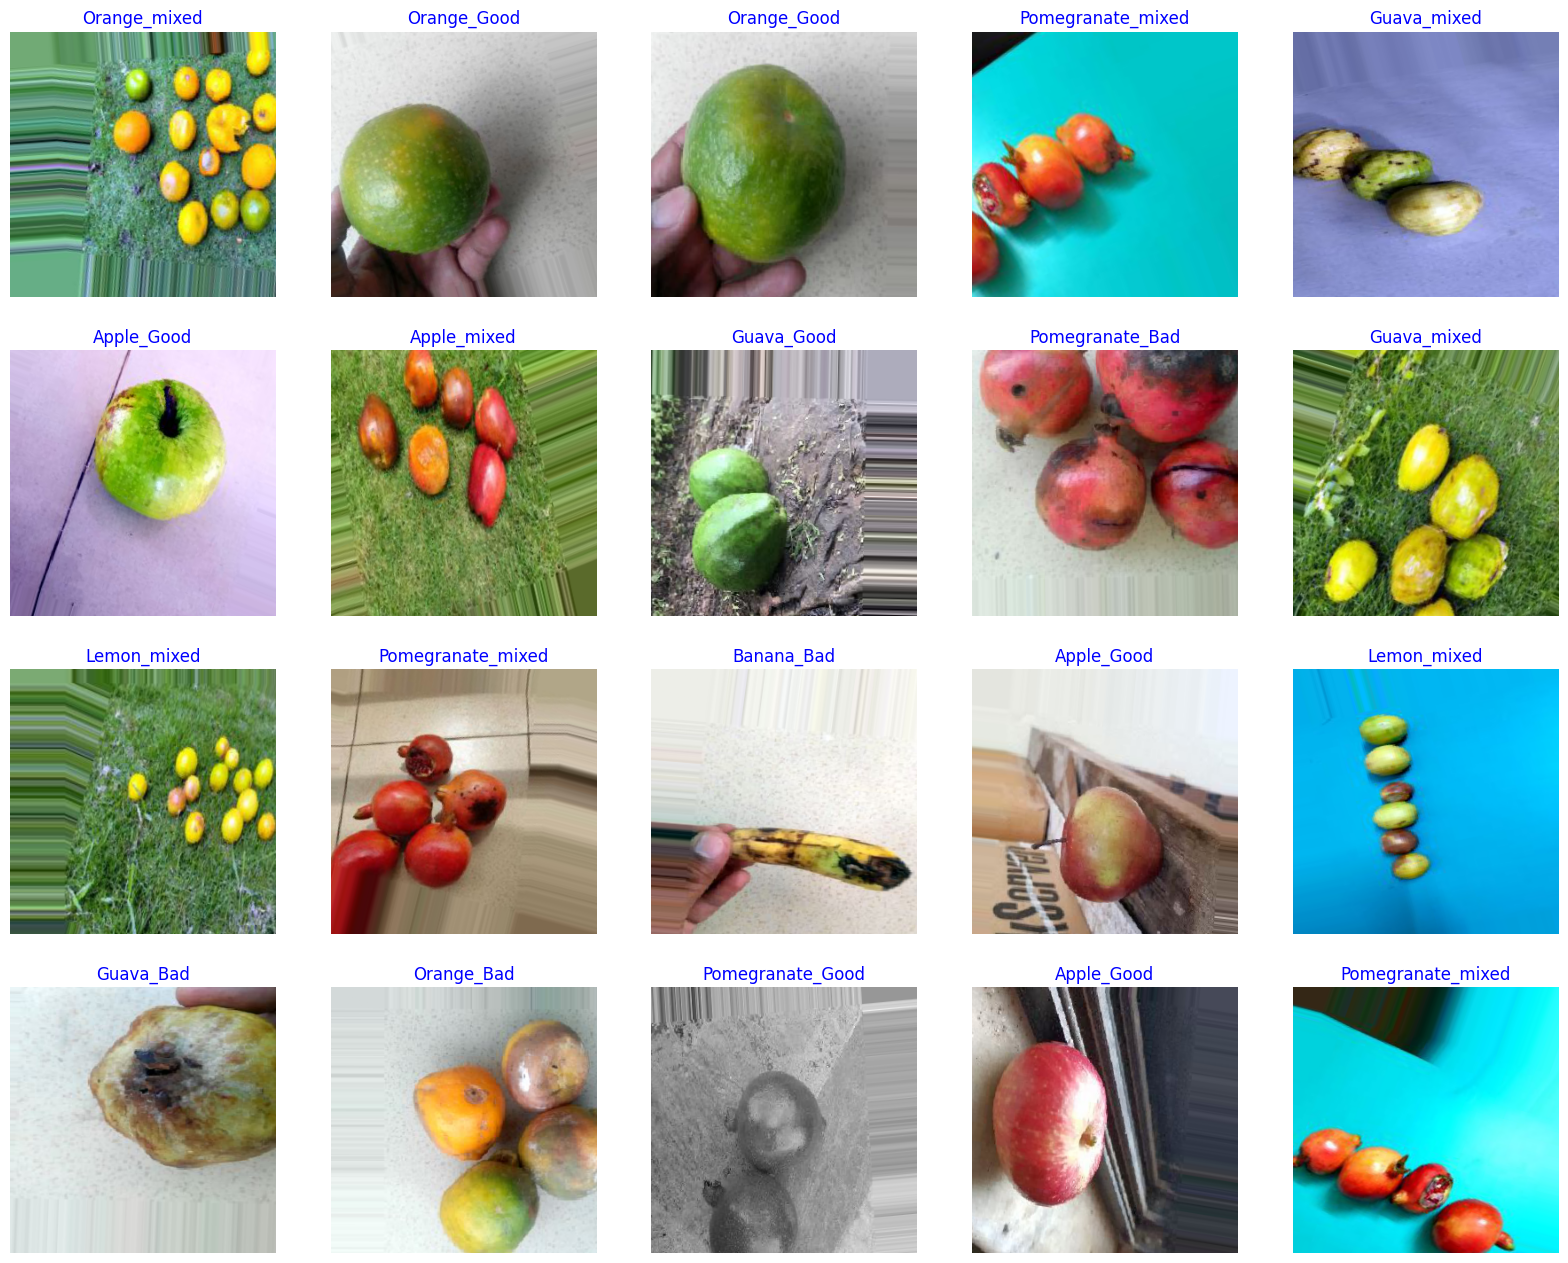

In [ ]:
def show_image_samples(gen):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen)

Creating a model using transfer learning with EfficientNetB5

In [ ]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB5'
base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model.trainable=True
x=base_model.output

x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

115263384/115263384 [==============================] - 1s 0us/step


Creating a custom Keras callback to continue or halt training

In [ ]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch):
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True
        
    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs:
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False
        if self.epochs == 1:
            self.ask=False
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        tr_duration=time.time() - self.start_time   
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True)
        
    def on_epoch_end(self, epoch, logs=None):
        if self.ask:
            if epoch + 1 ==self.ask_epoch:
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                if ans == 'H' or ans =='h' or ans == '0':
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

Instantiate custom callback and create 2 callbacks to control learning rate and early stop

In [ ]:
epochs=40
ask_epoch=5
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

**Train the model**




In [ ]:
fruit_model=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
270/270 [==============================] - 532s 2s/step - loss: 21.5156 - accuracy: 0.1757 - val_loss: 16.9214 - val_accuracy: 0.4373 - lr: 0.0010
Epoch 2/40
270/270 [==============================] - 323s 1s/step - loss: 13.7826 - accuracy: 0.6035 - val_loss: 10.6861 - val_accuracy: 0.9093 - lr: 0.0010
Epoch 3/40
270/270 [==============================] - 321s 1s/step - loss: 9.0557 - accuracy: 0.8948 - val_loss: 7.1022 - val_accuracy: 0.9735 - lr: 0.0010
Epoch 4/40
270/270 [==============================] - 322s 1s/step - loss: 6.0437 - accuracy: 0.9548 - val_loss: 4.7002 - val_accuracy: 0.9847 - lr: 0.0010
Epoch 5/40
270/270 [==============================] - ETA: 0s - loss: 3.9955 - accuracy: 0.9731
 Enter H to end training or  an integer for the number of additional epochs to run then ask again
2
you entered  2 

Function to plot the training data

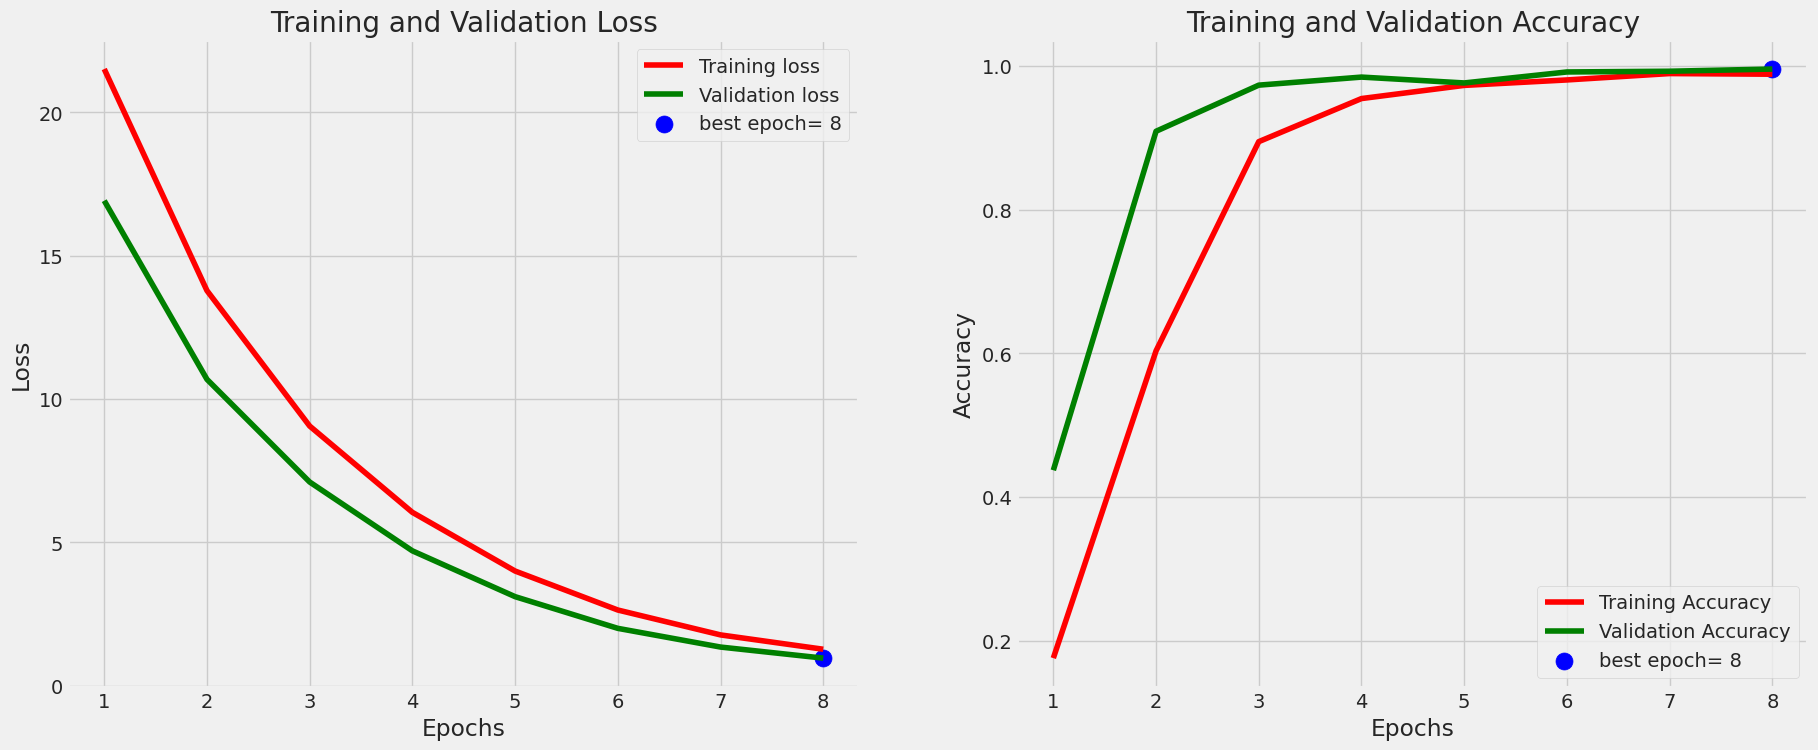

In [ ]:
def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(fruit_model,0)

Make predictions on test set, create Confusion Matrix and Classification Results

14/14 [==============================] - 90s 6s/step
there were 6 errors in 980 tests for an accuracy of  99.39%


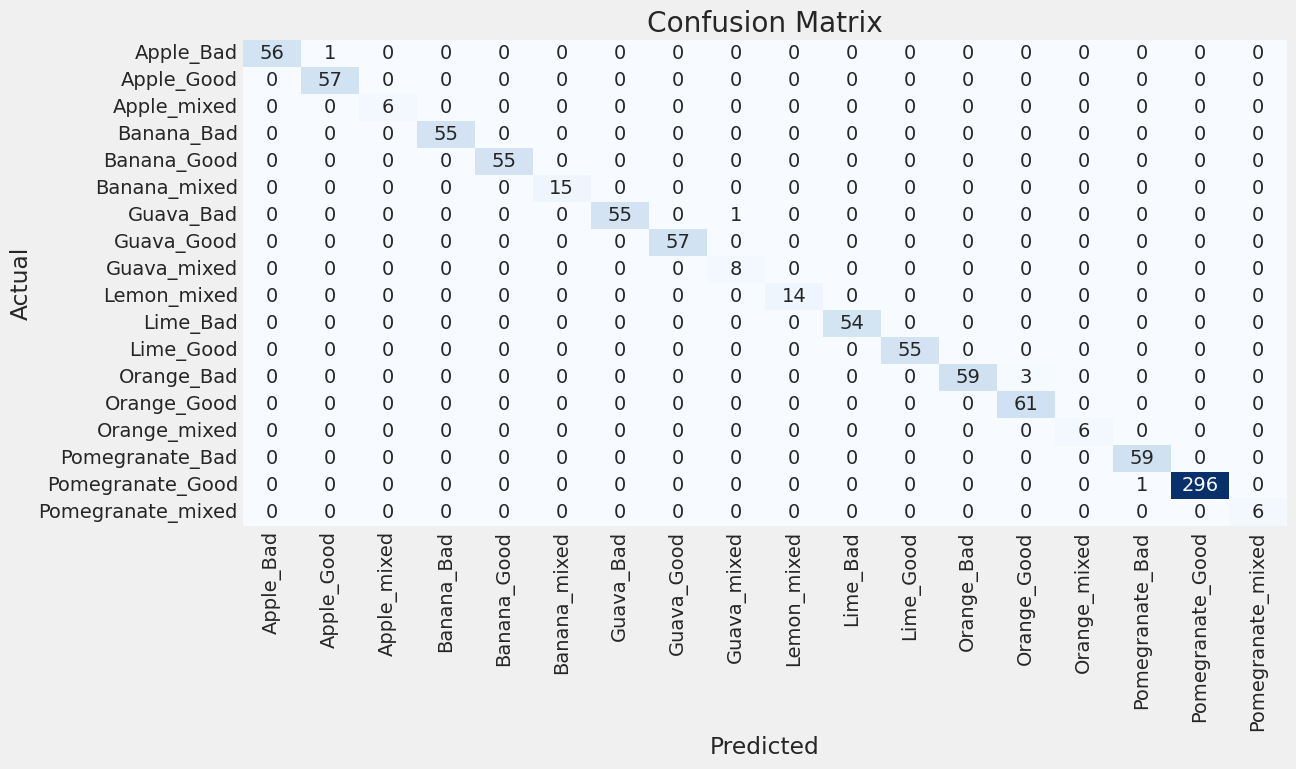

Classification Report:
----------------------
                    precision    recall  f1-score   support

        Apple_Bad     1.0000    0.9825    0.9912        57
       Apple_Good     0.9828    1.0000    0.9913        57
      Apple_mixed     1.0000    1.0000    1.0000         6
       Banana_Bad     1.0000    1.0000    1.0000        55
      Banana_Good     1.0000    1.0000    1.0000        55
     Banana_mixed     1.0000    1.0000    1.0000        15
        Guava_Bad     1.0000    0.9821    0.9910        56
       Guava_Good     1.0000    1.0000    1.0000        57
      Guava_mixed     0.8889    1.0000    0.9412         8
      Lemon_mixed     1.0000    1.0000    1.0000        14
         Lime_Bad     1.0000    1.0000    1.0000        54
        Lime_Good     1.0000    1.0000    1.0000        55
       Orange_Bad     1.0000    0.9516    0.9752        62
      Orange_Good     0.9531    1.0000    0.9760        61
     Orange_mixed     1.0000    1.0000    1.0000         6
  Pomegr

In [ ]:
y_pred= []
y_true=test_gen.labels
errors=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]
        if pred_index != true_index:                                         
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )

# confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)

In [ ]:
import datetime
def get_time():

    # Get the current time
    current_time = datetime.datetime.now()

    # Format the current time to display day, hour, and minute
    formatted_time = current_time.strftime("%d_%H:%M")

    return formatted_time

Save as h5

In [ ]:
subject='Fruit_model' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) 
# model_save_loc=os.path.join(r'/content/gdrive/MyDrive/models', save_id + get_time() + '.h5')
# model.save(model_save_loc)

Convert model to tflite and save it to disk

In [ ]:
import tensorflow as tf


# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
tflite_model_save_loc = os.path.join(r'/content/gdrive/MyDrive/models/', save_id + "_" + get_time() + '.tflite')
with open(tflite_model_save_loc, 'wb') as f:
    f.write(tflite_model)


Load tflite Model

In [ ]:
import tensorflow as tf

# Specify the path to the TFLite model file
# model_path = "/content/gdrive/MyDrive/models/Fruit_model_98.97_06_19:00.tflite"
model_path = "/content/gdrive/MyDrive/models/Fruit_model_99.38_07_16:23.tflite"

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()


In [ ]:
# Get the input and output details of the TFLite model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)
# Set the input tensor with the prepared input data
# interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
# interpreter.invoke()

# Get the output tensor
# output_data = interpreter.get_tensor(output_details[0]['index'])


[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 300, 300,   3], dtype=int32), 'shape_signature': array([ -1, 300, 300,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 1158, 'shape': array([ 1, 18], dtype=int32), 'shape_signature': array([-1, 18], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Load and preprocess the single image
image_path = '/content/test1.jpg'  # Replace with the actual path to your image
img = load_img(image_path, target_size=img_size)
img_array = img_to_array(img)
# preprocessed_img = tf.image.per_image_standardization(img_array)

# Reshape the image array to match the expected input shape of the model
preprocessed_img = img_array.reshape((1,) + img_array.shape)



In [ ]:
pred = model.predict(preprocessed_img)
print(pred)
cl = np.argmax(pred)
print(classes[cl])

1/1 [==============================] - 0s 47ms/step
[[1.2741145e-03 2.0401131e-03 2.6915600e-03 7.2409032e-04 2.7825239e-03
  5.2716985e-04 6.1956758e-04 3.8509674e-03 6.0014683e-03 8.0595323e-04
  7.9964270e-04 1.8811751e-03 1.7998054e-03 1.4720352e-03 1.4086904e-03
  5.7217362e-03 9.6097201e-01 4.6274317e-03]]
Pomegranate_Good


In [ ]:
interpreter.set_tensor(input_details[0]['index'], preprocessed_img)
interpreter.invoke()

In [ ]:
# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

# Interpret the output and print the predicted class
predicted_class_index = np.argmax(output_data)
predicted_class_label = classes[predicted_class_index]

print("Predicted class:", predicted_class_label)


[[1.2741187e-03 2.0401224e-03 2.6915662e-03 7.2409370e-04 2.7825383e-03
  5.2717235e-04 6.1956991e-04 3.8509853e-03 6.0014790e-03 8.0595620e-04
  7.9964643e-04 1.8811821e-03 1.7998095e-03 1.4720400e-03 1.4086944e-03
  5.7217493e-03 9.6097189e-01 4.6274443e-03]]
Predicted class: Pomegranate_Good


Load SavedModel

In [ ]:
import tensorflow as tf

# Specify the path to the SavedModel directory
saved_model_path = '/content/gdrive/MyDrive/Fruit_Model_99.69'

# Load the SavedModel
loaded_model = tf.saved_model.load(saved_model_path)
# Get the inference function or signature from the loaded model
inference_fn = loaded_model.signatures['serving_default']

# Perform inference using the model
input_data = preprocessed_img
output = inference_fn(input_data)
prnt(output)

Load h5 model

In [ ]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('path/to/model.h5')

# Prepare the input
input_data = ...  # Your input data here

# Preprocess the input (if needed)
preprocessed_input = ...  # Preprocess the input data as required by the model

# Run prediction on the preprocessed input
predictions = model.predict(preprocessed_input)

# Process the predictions
# ...

print(predictions)


In [ ]:
print(classes)

['Apple_Bad', 'Apple_Good', 'Apple_mixed', 'Banana_Bad', 'Banana_Good', 'Banana_mixed', 'Guava_Bad', 'Guava_Good', 'Guava_mixed', 'Lemon_mixed', 'Lime_Bad', 'Lime_Good', 'Orange_Bad', 'Orange_Good', 'Orange_mixed', 'Pomegranate_Bad', 'Pomegranate_Good', 'Pomegranate_mixed']


In [ ]:
drive.flush_and_unmount()